In [149]:
import scipy as sp
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import uncertainties
import urllib2
%matplotlib inline
%load_ext ipycache
import probfit
import iminuit
import copy
import numba
import os
%config InlineBackend.figure_format = 'svg'
exec(open('settings.py').read(), globals())

The ipycache extension is already loaded. To reload it, use:
  %reload_ext ipycache


In [2]:
%%cache outgrowth.pkl outgrowth
outgrowth_file = urllib2.urlopen('https://raw.githubusercontent.com/fabianrost84/Rost-Rodrigo-Albors-et-al-2016/v0.1-alpha/data/outgrowth.csv')
outgrowth = pd.read_csv(outgrowth_file)
outgrowth['length'] = outgrowth['length'] / 1000.0

[Skipped the cell's code and loaded variables outgrowth from file '/media/500G/fabian/work/axolotl/git/axolotl-calculations-phd/outgrowth.pkl'.]


In [3]:
mean_outgrowth = outgrowth.groupby('time').agg(['mean', 'sem'])
mean_outgrowth

length          
          mean       sem
time                    
0.0   0.000000  0.000000
2.0   0.056500  0.009006
3.0   0.163286  0.020837
4.0   0.451750  0.041292
6.0   1.278500  0.056770
8.0   2.257250  0.072343

In [4]:
minuits = {}

# LS approach

## Fit with Malthusian growth model

In [5]:
def malthusian_model(time, L0, r):
    return L0 * (sp.exp(r * time) - 1.0) 

### Assuming $L_0 = 500 \mu m$

In [6]:
L0 = 0.5

In [7]:
chi2_malt_500 = probfit.Chi2Regression(malthusian_model, sp.array(mean_outgrowth.index)[1:],
                                sp.array(mean_outgrowth['length', 'mean'])[1:],
                                sp.array(mean_outgrowth['length', 'sem'])[1:])

minuits['malt_500'] = iminuit.Minuit(chi2_malt_500, 
                        L0 = 0.5, error_L0 = 0.1, fix_L0 = True, 
                        r = 1.0, error_r = 0.1)

minuits['malt_500'].migrad();

FCN = 501.994752294 
 TOTAL NCALL = 64 
 NCALLS = 64 
 
 
 EDM = 9.22796792103e-09 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,L0,5.000000e-01,1.000000e-01,0.000000e+00,0.000000e+00,,,FIXED
2,r,1.683228e-01,3.229909e-03,0.000000e+00,0.000000e+00,,,


### Fitting $L_0$ and $r$

In [8]:
chi2_malt = probfit.Chi2Regression(malthusian_model,sp.array(mean_outgrowth.index)[1:],
                                sp.array(mean_outgrowth['length', 'mean'])[1:],
                                sp.array(mean_outgrowth['length', 'sem'])[1:])

minuits['malt'] = iminuit.Minuit(chi2_malt, L0 = 3.8, r = 0.001, error_L0 = 0.1, error_r = 0.1, limit_L0 = (0.5, None))

minuits['malt'].migrad();

FCN = 501.994752553 
 TOTAL NCALL = 307 
 NCALLS = 307 
 
 
 EDM = 2.6829797996e-07 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,L0,5.000000e-01,1.658986e-03,0.000000e+00,0.000000e+00,0.5,,
2,r,1.683228e-01,3.229911e-03,0.000000e+00,0.000000e+00,,,


### Biphasic model

In [9]:
@numba.njit
def biphase_model(time, L0, r1, r2, tswitch):
    if tswitch <= 0:
        return L0 * (sp.exp(r2 * time) - 1.0) 
    else:
        if time <= tswitch:
            return L0 * (sp.exp(r1 * time) - 1.0) 
        else:
            L1 = L0 * (sp.exp(r1 * tswitch) - 1.0) + L0
            return L1 * (sp.exp(r2 * (time - tswitch)) - 1.0)  + L1 - L0

In [10]:
chi2_biphase_500 = probfit.Chi2Regression(biphase_model,
                                sp.array(mean_outgrowth.index)[1:],
                                sp.array(mean_outgrowth['length', 'mean'])[1:],
                                sp.array(mean_outgrowth['length', 'sem'])[1:])

minuits['biphase_500'] = iminuit.Minuit(chi2_biphase_500, L0 = 0.5, error_L0 = 0.1, fix_L0 = True, limit_L0 = (0.5, None),
                                        r1 = 0.10, r2 = 0.1, tswitch = 3.0,\
                                        error_r1 = 0.01, error_r2 = 0.01, error_tswitch = 0.1,
                                        limit_r1 = (0, None), limit_r2 = (0, None))

minuits['biphase_500'].migrad();

FCN = 12.195768939 
 TOTAL NCALL = 100 
 NCALLS = 100 
 
 
 EDM = 1.75233761866e-07 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,L0,5.000000e-01,1.000000e-01,0.000000e+00,0.000000e+00,0.5,,FIXED
2,r1,5.353064e-02,8.090032e-03,0.000000e+00,0.000000e+00,0.0,,
3,r2,2.831553e-01,7.386990e-03,0.000000e+00,0.000000e+00,0.0,,
4,tswitch,2.282289e+00,1.527460e-01,0.000000e+00,0.000000e+00,,,


In [11]:
minuits['biphase_500'].minos('tswitch', sigma = 2)

Error,-0.657397347273,0.307023008118
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


{'tswitch': {'lower_new_min': False, 'upper': 0.30702300811770783, 'lower': -0.6573973472728801, 'at_lower_limit': False, 'min': 2.2822890671765617, 'at_lower_max_fcn': False, 'is_valid': True, 'upper_new_min': False, 'at_upper_limit': False, 'lower_valid': True, 'upper_valid': True, 'at_upper_max_fcn': False, 'nfcn': 226}}

In [12]:
chi2_biphase_800 = probfit.Chi2Regression(biphase_model,
                                sp.array(mean_outgrowth.index)[1:],
                                sp.array(mean_outgrowth['length', 'mean'])[1:],
                                sp.array(mean_outgrowth['length', 'sem'])[1:])

minuits['biphase_800'] = iminuit.Minuit(chi2_biphase_800, L0 = 0.8, error_L0 = 0.1, fix_L0 = True, limit_L0 = (0.5, None),
                                        r1 = 0.10, r2 = 0.1, tswitch = 3.0,\
                                        error_r1 = 0.01, error_r2 = 0.01, error_tswitch = 0.1,
                                        limit_r1 = (0, None), limit_r2 = (0, None))

minuits['biphase_800'].migrad();

FCN = 5.64931159119 
 TOTAL NCALL = 134 
 NCALLS = 134 
 
 
 EDM = 2.04136461175e-08 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,L0,8.000000e-01,1.000000e-01,0.000000e+00,0.000000e+00,0.5,,FIXED
2,r1,3.412104e-02,5.256622e-03,0.000000e+00,0.000000e+00,0.0,,
3,r2,2.323232e-01,5.989815e-03,0.000000e+00,0.000000e+00,0.0,,
4,tswitch,2.494995e+00,1.240838e-01,0.000000e+00,0.000000e+00,,,


In [13]:
chi2_biphase = probfit.Chi2Regression(biphase_model,
                                sp.array(mean_outgrowth.index)[1:],
                                sp.array(mean_outgrowth['length', 'mean'])[1:],
                                sp.array(mean_outgrowth['length', 'sem'])[1:])

minuits['biphase'] = iminuit.Minuit(chi2_biphase, L0 = 0.8, r1 = 0.10, r2 = 0.1, tswitch = 3.0, limit_L0 = (0.5, None),
                         error_L0 = 0.1, error_r1 = 0.01, error_r2 = 0.01, error_tswitch = 0.1,
                         limit_r1 = (0, None), limit_r2 = (0, None))

minuits['biphase'].migrad();

FCN = 0.613973110817 
 TOTAL NCALL = 327 
 NCALLS = 327 
 
 
 EDM = 9.14371932715e-07 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,L0,2.045767e+00,9.680653e-01,0.000000e+00,0.000000e+00,0.5,,
2,r1,1.362036e-02,6.800039e-03,0.000000e+00,0.000000e+00,0.0,,
3,r2,1.341681e-01,4.448954e-02,0.000000e+00,0.000000e+00,0.0,,
4,tswitch,2.715637e+00,1.123790e-01,0.000000e+00,0.000000e+00,,,


## Model comparison

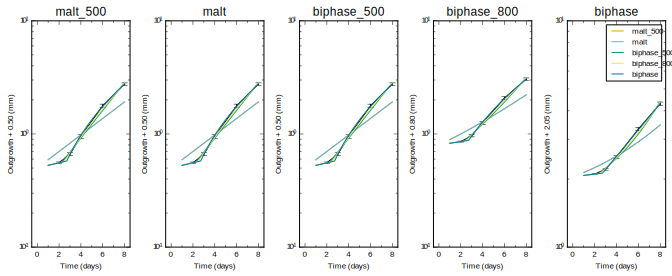

In [14]:
time = sp.linspace(1, 8)

minuit_names = ['malt_500', 'malt', 'biphase_500', 'biphase_800', 'biphase'] 

fig, axs = plt.subplots(1, len(minuit_names), figsize=(3*80/25.4,100.0/25.4), sharex = True)
fig.patch.set_alpha(1.0)

for ax, name in zip(axs, minuit_names):
    M = minuits[name]
    L0plot = M.values['L0']
    ax.errorbar(sp.array(mean_outgrowth.index)[1:],
                sp.array(mean_outgrowth['length', 'mean'])[1:]+ L0plot,
                sp.array(mean_outgrowth['length', 'sem'])[1:]
               )
    for name_plot in minuit_names:
        ax.plot(time, sp.vectorize(minuits[name_plot].fcn.f)(time, **minuits[name_plot].values) + L0plot,
                label = name_plot)
        
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Outgrowth + {0:.2f} (mm)'.format(L0plot))
    ax.set_title(name)

    ax.set_xlim(-0.5, 8.5)
    ax.set_xticks([1, 3, 5, 7], minor=True)
    ax.set_yscale('log')

plt.legend()
plt.tight_layout()
plt.show()

only the fixed 500 models

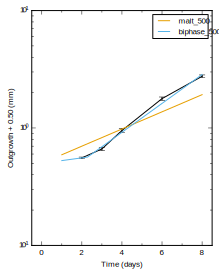

In [15]:
time = sp.linspace(1, 8)

minuit_names = ['malt_500', 'biphase_500'] 

fig, ax = plt.subplots(1, 1, figsize=(80/25.4,100.0/25.4), sharex = True)
fig.patch.set_alpha(1.0)

M = minuits[name]
L0plot = 0.5
ax.errorbar(sp.array(mean_outgrowth.index)[1:],
            sp.array(mean_outgrowth['length', 'mean'])[1:]+ L0plot,
            sp.array(mean_outgrowth['length', 'sem'])[1:]
           )
for name_plot in minuit_names:
    ax.plot(time, sp.vectorize(minuits[name_plot].fcn.f)(time, **minuits[name_plot].values) + L0plot,
            label = name_plot)

ax.set_xlabel('Time (days)')
ax.set_ylabel('Outgrowth + {0:.2f} (mm)'.format(L0plot))

ax.set_xlim(-0.5, 8.5)
ax.set_xticks([1, 3, 5, 7], minor=True)
ax.set_yscale('log')

plt.legend()
plt.tight_layout()
plt.show()

#### GOF

In [16]:
def free_parameters(minuit):
    return int(len(minuit.values) - sp.sum([minuit.is_fixed(p) for p in minuit.values.iterkeys()]))

In [17]:
def GOF(minuit):
    ddof = minuit.fcn.data_len - free_parameters(minuit)
    p = 1 - sp.stats.chi2.cdf(M.fval, ddof)
    return p

In [18]:
for name, M in minuits.iteritems():
    print name
    print "p: {0:.2g}".format(GOF(M))

malt_500
p: 0
biphase_500
p: 0.0022
malt
p: 0
biphase_800
p: 0.059
biphase
p: 0.43


#### AIC

In [19]:
def AIC_SSE(minuit):
    SSE = minuit.fval
    ## only works if no fixed paramters are used
    k = free_parameters(minuit)
    AIC = 2 * k + SSE
    return AIC

def AICc_SSE(minuit):
    try:
        AICv = AIC_SSE(minuit)
        k = free_parameters(minuit)
        n = minuit.fcn.data_len
        AICc = AICv + 2 * k * (k + 1) / (n - k - 1)
    except:
        AICc = sp.nan
    
    return AICc

In [20]:
for name, M in minuits.iteritems():
    print name
    print 'AIC:  {}'.format(AIC_SSE(M))
    print 'AICc: {}'.format(AICc_SSE(M))

malt_500
AIC:  503.994752294
AICc: 504.994752294
biphase_500
AIC:  18.195768939
AICc: 42.195768939
malt
AIC:  505.994752553
AICc: 511.994752553
biphase_800
AIC:  11.6493115912
AICc: 35.6493115912
biphase
AIC:  8.61397311082
AICc: nan


# ML approach

In [21]:
times = sp.array(outgrowth.query('time > 0')['time'].astype(int))
lengths = sp.array(outgrowth.query('time > 0')['length'])

In [38]:
@numba.jit
def negloglike(L0, r1, r2, tswitch, sigma2, sigma3, sigma4, sigma6, sigma8):
    loglike = 0.0 
    
        
    
    Lexps = sp.empty(len(times))
    Lmodels = sp.empty(len(times))
    sigmas = sp.empty(len(times))
    for i, (time, length) in enumerate(zip(times, lengths)):
        Lexp = length       
        Lmodel = biphase_model(float(time), L0, r1, r2, tswitch)
        if time == 2:
            sigma = sigma2
        elif time == 3:
            sigma = sigma3
        elif time == 4:
            sigma = sigma4
        elif time == 6:
            sigma = sigma6
        elif time == 8:
            sigma = sigma8
        Lexps[i] = Lexp
        Lmodels[i] = Lmodel
        sigmas[i] = sigma
        
            
    loglike = sp.stats.norm.logpdf(Lexps, loc=Lmodels, scale=sigmas).sum()
    return -loglike
negloglike.data_len = len(time)

In [39]:
def generate_initial():
    L0 = sp.random.uniform(0.5, 3)
    r1 = sp.random.uniform(0, 1)
    r2 = sp.random.uniform(0, 1)
    tswitch = sp.random.uniform(0, 8)
    return L0, r1, r2, tswitch

In [40]:
N = 10

In [41]:
minuits = {}

## Fit with Malthusian growth model

### Assuming $L_0 = 500 \mu m$

In [53]:
fval = sp.inf
L0_best, r1_best, r2_best, tswitch_best = sp.nan, sp.nan, sp.nan, sp.nan, 
for i in range(N):
    L0, r1, r2, tswitch = generate_initial()
    L0 = 0.5
    tswitch = 1e99
    fix_L0 = True
    fix_r2 = True
    fix_tswitch = True
    M = iminuit.Minuit(negloglike, errordef=0.5,
                               L0 = L0, error_L0 = 0.01, limit_L0 = (0.5, None), fix_L0 = fix_L0,
                               r1 = r1, error_r1 = 0.01, limit_r1 = (0, None), fix_r1 = False,
                               r2 = r2, error_r2 = 0.01, limit_r2 = (0, None), fix_r2 = fix_r2,
                               tswitch = tswitch, error_tswitch = 0.1, limit_tswitch = (0, None), fix_tswitch = fix_tswitch,
                               sigma2 = 0.1, error_sigma2 = 0.01, limit_sigma2 = (0, None),
                               sigma3 = 0.1, error_sigma3 = 0.01, limit_sigma3 = (0, None),
                               sigma4 = 0.1, error_sigma4 = 0.01, limit_sigma4 = (0, None),
                               sigma6 = 0.1, error_sigma6 = 0.01, limit_sigma6 = (0, None),
                               sigma8 = 0.1, error_sigma8 = 0.01, limit_sigma8 = (0, None),
                               print_level = 0
                              )
    M.migrad();
    if (M.fval < fval) and M.migrad_ok():
        fval = M.fval
        L0_best, r1_best, r2_best, tswitch_best = L0, r1, r2, tswitch

L0, r1, r2, tswitch = L0_best, r1_best, r2_best, tswitch_best
minuits['malt_500'] = iminuit.Minuit(negloglike, errordef=0.5,
                               L0 = L0, error_L0 = 0.01, limit_L0 = (0.5, None), fix_L0 = fix_L0,
                               r1 = r1, error_r1 = 0.01, limit_r1 = (0, None), fix_r1 = False,
                               r2 = r2, error_r2 = 0.01, limit_r2 = (0, None), fix_r2 = fix_r2,
                               tswitch = tswitch, error_tswitch = 0.1, limit_tswitch = (0, None), fix_tswitch = fix_tswitch,
                               sigma2 = 0.1, error_sigma2 = 0.01, limit_sigma2 = (0, None),
                               sigma3 = 0.1, error_sigma3 = 0.01, limit_sigma3 = (0, None),
                               sigma4 = 0.1, error_sigma4 = 0.01, limit_sigma4 = (0, None),
                               sigma6 = 0.1, error_sigma6 = 0.01, limit_sigma6 = (0, None),
                               sigma8 = 0.1, error_sigma8 = 0.01, limit_sigma8 = (0, None)
                              )
minuits['malt_500'].migrad();

FCN = -5.67347109541 
 TOTAL NCALL = 858 
 NCALLS = 858 
 
 
 EDM = 4.75351761819e-09 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,L0,5.000000e-01,1.000000e-02,0.000000e+00,0.000000e+00,0.5,,FIXED
2,r1,2.108763e-01,2.945067e-03,0.000000e+00,0.000000e+00,0.0,,
3,r2,3.348052e-01,1.000000e-02,0.000000e+00,0.000000e+00,0.0,,FIXED
4,tswitch,1.000000e+99,1.000000e-01,0.000000e+00,0.000000e+00,0.0,,FIXED
5,sigma2,2.071903e-01,5.188375e-02,0.000000e+00,0.000000e+00,0.0,,
6,sigma3,2.826374e-01,7.577256e-02,0.000000e+00,0.000000e+00,0.0,,
7,sigma4,2.371606e-01,6.038477e-02,0.000000e+00,0.000000e+00,0.0,,
8,sigma6,1.503379e-01,3.754602e-02,0.000000e+00,0.000000e+00,0.0,,
9,sigma8,1.993171e-01,5.277405e-02,0.000000e+00,0.000000e+00,0.0,,


### Not assuming $L_0 = 500 \mu m$

In [55]:
fval = sp.inf
L0_best, r1_best, r2_best, tswitch_best = sp.nan, sp.nan, sp.nan, sp.nan, 
for i in range(N):
    L0, r1, r2, tswitch = generate_initial()
    tswitch = 1e99
    fix_L0 = False
    fix_r2 = True
    fix_tswitch = True
    M = iminuit.Minuit(negloglike, errordef=0.5,
                               L0 = L0, error_L0 = 0.01, limit_L0 = (0.5, None), fix_L0 = fix_L0,
                               r1 = r1, error_r1 = 0.01, limit_r1 = (0, None), fix_r1 = False,
                               r2 = r2, error_r2 = 0.01, limit_r2 = (0, None), fix_r2 = fix_r2,
                               tswitch = tswitch, error_tswitch = 0.1, limit_tswitch = (0, None), fix_tswitch = fix_tswitch,
                               sigma2 = 0.1, error_sigma2 = 0.01, limit_sigma2 = (0, None),
                               sigma3 = 0.1, error_sigma3 = 0.01, limit_sigma3 = (0, None),
                               sigma4 = 0.1, error_sigma4 = 0.01, limit_sigma4 = (0, None),
                               sigma6 = 0.1, error_sigma6 = 0.01, limit_sigma6 = (0, None),
                               sigma8 = 0.1, error_sigma8 = 0.01, limit_sigma8 = (0, None),
                               print_level = 0
                              )
    M.migrad();
    if (M.fval < fval) and M.migrad_ok():
        fval = M.fval
        L0_best, r1_best, r2_best, tswitch_best = L0, r1, r2, tswitch

L0, r1, r2, tswitch = L0_best, r1_best, r2_best, tswitch_best
minuits['malt'] = iminuit.Minuit(negloglike, errordef=0.5,
                               L0 = L0, error_L0 = 0.01, limit_L0 = (0.5, None), fix_L0 = fix_L0,
                               r1 = r1, error_r1 = 0.01, limit_r1 = (0, None), fix_r1 = False,
                               r2 = r2, error_r2 = 0.01, limit_r2 = (0, None), fix_r2 = fix_r2,
                               tswitch = tswitch, error_tswitch = 0.1, limit_tswitch = (0, None), fix_tswitch = fix_tswitch,
                               sigma2 = 0.1, error_sigma2 = 0.01, limit_sigma2 = (0, None),
                               sigma3 = 0.1, error_sigma3 = 0.01, limit_sigma3 = (0, None),
                               sigma4 = 0.1, error_sigma4 = 0.01, limit_sigma4 = (0, None),
                               sigma6 = 0.1, error_sigma6 = 0.01, limit_sigma6 = (0, None),
                               sigma8 = 0.1, error_sigma8 = 0.01, limit_sigma8 = (0, None)
                              )
minuits['malt'].migrad();

FCN = -5.67347106276 
 TOTAL NCALL = 735 
 NCALLS = 735 
 
 
 EDM = 3.74518222238e-08 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,L0,5.000000e-01,1.894863e-02,0.000000e+00,0.000000e+00,0.5,,
2,r1,2.108766e-01,2.945060e-03,0.000000e+00,0.000000e+00,0.0,,
3,r2,5.217106e-01,1.000000e-02,0.000000e+00,0.000000e+00,0.0,,FIXED
4,tswitch,1.000000e+99,1.000000e-01,0.000000e+00,0.000000e+00,0.0,,FIXED
5,sigma2,2.071880e-01,5.188225e-02,0.000000e+00,0.000000e+00,0.0,,
6,sigma3,2.826355e-01,7.577102e-02,0.000000e+00,0.000000e+00,0.0,,
7,sigma4,2.371631e-01,6.038567e-02,0.000000e+00,0.000000e+00,0.0,,
8,sigma6,1.503397e-01,3.754706e-02,0.000000e+00,0.000000e+00,0.0,,
9,sigma8,1.993208e-01,5.277626e-02,0.000000e+00,0.000000e+00,0.0,,


## Fit with Biphase

### Assuming $L_0 = 500 \mu m$

In [56]:
fval = sp.inf
L0_best, r1_best, r2_best, tswitch_best = sp.nan, sp.nan, sp.nan, sp.nan, 
for i in range(N):
    L0, r1, r2, tswitch = generate_initial()
    L0 = 0.5
    fix_L0 = True
    fix_r2 = False
    fix_tswitch = False
    M = iminuit.Minuit(negloglike, errordef=0.5,
                               L0 = L0, error_L0 = 0.01, limit_L0 = (0.5, None), fix_L0 = fix_L0,
                               r1 = r1, error_r1 = 0.01, limit_r1 = (0, None), fix_r1 = False,
                               r2 = r2, error_r2 = 0.01, limit_r2 = (0, None), fix_r2 = fix_r2,
                               tswitch = tswitch, error_tswitch = 0.1, limit_tswitch = (0, None), fix_tswitch = fix_tswitch,
                               sigma2 = 0.1, error_sigma2 = 0.01, limit_sigma2 = (0, None),
                               sigma3 = 0.1, error_sigma3 = 0.01, limit_sigma3 = (0, None),
                               sigma4 = 0.1, error_sigma4 = 0.01, limit_sigma4 = (0, None),
                               sigma6 = 0.1, error_sigma6 = 0.01, limit_sigma6 = (0, None),
                               sigma8 = 0.1, error_sigma8 = 0.01, limit_sigma8 = (0, None),
                               print_level = 0
                              )
    M.migrad();
    if (M.fval < fval) and M.migrad_ok():
        fval = M.fval
        L0_best, r1_best, r2_best, tswitch_best = L0, r1, r2, tswitch

L0, r1, r2, tswitch = L0_best, r1_best, r2_best, tswitch_best
minuits['biphase_500'] = iminuit.Minuit(negloglike, errordef=0.5,
                               L0 = L0, error_L0 = 0.01, limit_L0 = (0.5, None), fix_L0 = fix_L0,
                               r1 = r1, error_r1 = 0.01, limit_r1 = (0, None), fix_r1 = False,
                               r2 = r2, error_r2 = 0.01, limit_r2 = (0, None), fix_r2 = fix_r2,
                               tswitch = tswitch, error_tswitch = 0.1, limit_tswitch = (0, None), fix_tswitch = fix_tswitch,
                               sigma2 = 0.1, error_sigma2 = 0.01, limit_sigma2 = (0, None),
                               sigma3 = 0.1, error_sigma3 = 0.01, limit_sigma3 = (0, None),
                               sigma4 = 0.1, error_sigma4 = 0.01, limit_sigma4 = (0, None),
                               sigma6 = 0.1, error_sigma6 = 0.01, limit_sigma6 = (0, None),
                               sigma8 = 0.1, error_sigma8 = 0.01, limit_sigma8 = (0, None)
                              )
minuits['biphase_500'].migrad();

FCN = -36.4485638135 
 TOTAL NCALL = 1198 
 NCALLS = 1198 
 
 
 EDM = 1.2209032949e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,L0,5.000000e-01,1.000000e-02,0.000000e+00,0.000000e+00,0.5,,FIXED
2,r1,5.352488e-02,7.568278e-03,0.000000e+00,0.000000e+00,0.0,,
3,r2,2.819917e-01,8.539750e-03,0.000000e+00,0.000000e+00,0.0,,
4,tswitch,2.319613e+00,1.802354e-01,0.000000e+00,0.000000e+00,0.0,,
5,sigma2,2.382734e-02,5.954692e-03,0.000000e+00,0.000000e+00,0.0,,
6,sigma3,5.580344e-02,1.740029e-02,0.000000e+00,0.000000e+00,0.0,,
7,sigma4,1.172324e-01,3.053472e-02,0.000000e+00,0.000000e+00,0.0,,
8,sigma6,2.347494e-01,6.368067e-02,0.000000e+00,0.000000e+00,0.0,,
9,sigma8,1.982779e-01,5.322587e-02,0.000000e+00,0.000000e+00,0.0,,


### Not assuming $L_0 = 500 \mu m$

In [44]:
fval = sp.inf
L0_best, r1_best, r2_best, tswitch_best = sp.nan, sp.nan, sp.nan, sp.nan, 
for i in range(N):
    L0, r1, r2, tswitch = generate_initial()
#     L0 = 2.5
#     r1 = 0.1
#     r2 = 0.1
    fix_L0 = False
    fix_r2 = False
    fix_tswitch = False
    M = iminuit.Minuit(negloglike, errordef=0.5,
                               L0 = L0, error_L0 = 0.01, limit_L0 = (0.5, None), fix_L0 = fix_L0,
                               r1 = r1, error_r1 = 0.01, limit_r1 = (0, None), fix_r1 = False,
                               r2 = r2, error_r2 = 0.01, limit_r2 = (0, None), fix_r2 = fix_r2,
                               tswitch = tswitch, error_tswitch = 0.1, limit_tswitch = (0, None), fix_tswitch = fix_tswitch,
                               sigma2 = 0.1, error_sigma2 = 0.01, limit_sigma2 = (0, None),
                               sigma3 = 0.1, error_sigma3 = 0.01, limit_sigma3 = (0, None),
                               sigma4 = 0.1, error_sigma4 = 0.01, limit_sigma4 = (0, None),
                               sigma6 = 0.1, error_sigma6 = 0.01, limit_sigma6 = (0, None),
                               sigma8 = 0.1, error_sigma8 = 0.01, limit_sigma8 = (0, None),
                               print_level = 0
                              )
    M.migrad();
    if (M.fval < fval) and M.migrad_ok():
        fval = M.fval
        L0_best, r1_best, r2_best, tswitch_best = L0, r1, r2, tswitch

L0, r1, r2, tswitch = L0_best, r1_best, r2_best, tswitch_best
minuits['biphase'] = iminuit.Minuit(negloglike, errordef=0.5,
                               L0 = L0, error_L0 = 0.01, limit_L0 = (0.5, None), fix_L0 = fix_L0,
                               r1 = r1, error_r1 = 0.01, limit_r1 = (0, None), fix_r1 = False,
                               r2 = r2, error_r2 = 0.01, limit_r2 = (0, None), fix_r2 = fix_r2,
                               tswitch = tswitch, error_tswitch = 0.1, limit_tswitch = (0, None), fix_tswitch = fix_tswitch,
                               sigma2 = 0.1, error_sigma2 = 0.01, limit_sigma2 = (0, None),
                               sigma3 = 0.1, error_sigma3 = 0.01, limit_sigma3 = (0, None),
                               sigma4 = 0.1, error_sigma4 = 0.01, limit_sigma4 = (0, None),
                               sigma6 = 0.1, error_sigma6 = 0.01, limit_sigma6 = (0, None),
                               sigma8 = 0.1, error_sigma8 = 0.01, limit_sigma8 = (0, None)
                              )
minuits['biphase'].migrad();

FCN = -41.1448015723 
 TOTAL NCALL = 1338 
 NCALLS = 1338 
 
 
 EDM = 4.83130819122e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,L0,2.050926e+00,1.034737e+00,0.000000e+00,0.000000e+00,0.5,,
2,r1,1.358830e-02,7.175728e-03,0.000000e+00,0.000000e+00,0.0,,
3,r2,1.339048e-01,4.744098e-02,0.000000e+00,0.000000e+00,0.0,,
4,tswitch,2.715073e+00,1.088406e-01,0.000000e+00,0.000000e+00,0.0,,
5,sigma2,2.382854e-02,5.955385e-03,0.000000e+00,0.000000e+00,0.0,,
6,sigma3,5.115287e-02,1.372113e-02,0.000000e+00,0.000000e+00,0.0,,
7,sigma4,1.120404e-01,2.865637e-02,0.000000e+00,0.000000e+00,0.0,,
8,sigma6,1.523775e-01,3.886970e-02,0.000000e+00,0.000000e+00,0.0,,
9,sigma8,1.916954e-01,4.797975e-02,0.000000e+00,0.000000e+00,0.0,,


## Model comparison

In [129]:
def plot_model(fig, ax, time, M, label = None, L0plot = 0, color = 'black', ls = '-'):
    ax.plot(time, 
            sp.vectorize(biphase_model)(time, M.values['L0'], M.values['r1'], M.values['r2'], M.values['tswitch']) + L0plot,
           color = color,
           label = label, ls = ls)
    errortime = [2, 3, 4, 6, 8]
    sigmas = [M.values['sigma2'], M.values['sigma3'], M.values['sigma4'], M.values['sigma6'], M.values['sigma8']]
    ax.errorbar(errortime, 
                sp.vectorize(biphase_model)(errortime, M.values['L0'], M.values['r1'],
                                            M.values['r2'], M.values['tswitch']) + L0plot,
               sigmas,
               ls = '', color = color)
    

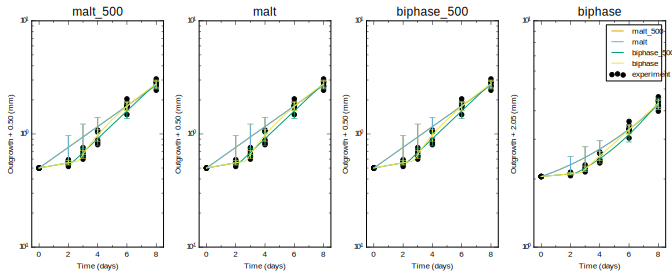

In [130]:
time = sp.linspace(0, 8)

minuit_names = ['malt_500', 'malt', 'biphase_500', 'biphase'] 

fig, axs = plt.subplots(1, len(minuit_names), figsize=(len(minuit_names)*60/25.4,100.0/25.4), sharex = True, squeeze=False)
fig.patch.set_alpha(1.0)

for ax, name in zip(axs[0], minuit_names):
    M = minuits[name]
    L0plot = M.values['L0']
    ax.scatter(outgrowth['time'], outgrowth['length'] + L0plot, label = 'experiment', color = 'black')
    for i, name_plot in enumerate(minuit_names):
        plot_model(fig, ax, time, minuits[name_plot], name_plot, L0plot, color=colorcycle[i+1])
        
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Outgrowth + {0:.2f} (mm)'.format(L0plot))
    ax.set_title(name)

    ax.set_xlim(-0.5, 8.5)
    ax.set_xticks([1, 3, 5, 7], minor=True)
    ax.set_yscale('log')

plt.legend()
plt.tight_layout()
plt.show()

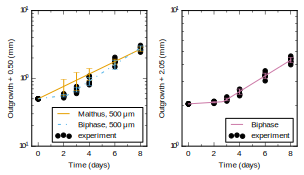

In [150]:
labels = {'malt_500': u'Malthus, 500 μm', 'biphase_500': u'Biphase, 500 μm                      ', 'biphase': 'Biphase'}
colors = {'malt_500': colorcycle[1], 'biphase_500': colorcycle[2], 'biphase': colorcycle[7]}
linestyles = {'malt_500': '-', 'biphase_500': '-.', 'biphase': '-'}
time = sp.linspace(0, 8)

fig, axs = plt.subplots(1, 2, figsize=(2*55/25.4,65.0/25.4), sharex = True)
fig.patch.set_alpha(1.0)

ax = axs[0]
L0plot = 0.5
ax.scatter(outgrowth['time'], outgrowth['length'] + L0plot, label = 'experiment             ', color = 'black')
for i, name_plot in enumerate(['malt_500', 'biphase_500']):
    plot_model(fig, ax, time, minuits[name_plot], labels[name_plot], L0plot, color=colors[name_plot], ls = linestyles[name_plot])
ax.set_xlabel('Time (days)')
ax.set_ylabel('Outgrowth + {0:.2f} (mm)'.format(L0plot))    
ax.legend(loc = 'lower right')
ax.set_yscale('log')

    
ax = axs[1]
L0plot = minuits['biphase'].values['L0']
ax.scatter(outgrowth['time'], outgrowth['length'] + L0plot, label = 'experiment             ', color = 'black')
for i, name_plot in enumerate(['biphase']):
    plot_model(fig, ax, time, minuits[name_plot], labels[name_plot], L0plot, color=colors[name_plot])

ax.set_xlabel('Time (days)')
ax.set_ylabel('Outgrowth + {0:.2f} (mm)'.format(L0plot))
ax.legend(loc = 'lower right')

ax.set_xlim(-0.5, 8.5)
ax.set_xticks([1, 3, 5, 7], minor=True)
ax.set_yscale('log')

plt.tight_layout()

exportname = 'outgrowth_proliferation_fit'
plt.savefig('{}.svg'.format(exportname))
os.system('inkscape -D -z --file={0}.svg --export-pdf={0}.pdf'.format(exportname))


plt.show()

### AIC

In [139]:
def AIC_loglike(minuit):
    loglike = -minuit.fval
    ## only works if no fixed paramters are used
    k = free_parameters(minuit)
    AIC = - 2 * loglike + 2 * k 
    return AIC

def AICc_loglike(minuit):
    try:
        AICv = AIC_loglike(minuit)
        k = free_parameters(minuit)
        n = minuit.fcn.data_len
        AICc = AICv + 2 * k * (k + 1) / (n - k - 1)
    except:
        AICc = sp.nan
    
    return AICc

In [140]:
for name, M in minuits.iteritems():
    print name
    print 'AIC:  {}'.format(AIC_loglike(M))
    print 'AICc: {}'.format(AICc_loglike(M))

malt
AIC:  2.65305787447
AICc: 4.65305787447
biphase_500
AIC:  -56.8971276271
AICc: -53.8971276271
malt_500
AIC:  0.653057809178
AICc: 1.65305780918
biphase
AIC:  -64.2896031446
AICc: -60.2896031446


`biphase` has the best AICc. Calculate evidence ratios:

In [141]:
def ER_loglike(minuit1, minuit2):
    AIC1 = AICc_loglike(minuit1)
    AIC2 = AICc_loglike(minuit2)
    dAIC = AIC2 - AIC1
    return sp.exp(0.5 * dAIC)

In [147]:
for name in ['malt', 'malt_500', 'biphase_500']:
    print 'ER ({0:11s}): {1:.2f}'.format(name, ER_loglike(minuit1=minuits['biphase'], minuit2=minuits[name]))

ER (malt       ): 126508486589953.69
ER (malt_500   ): 28227857951383.78
ER (biphase_500): 24.44
